# Kepler (minimum time orbit transfer) - Julia
![CNES](figs/logo-cnes.png) ![TAS](figs/logo-tas.png)

Minimum time control of the Kepler equation (CNES / TAS / Inria / CNRS collaboration):

$$ t_f \to \min, $$

$$ \ddot{q} = -\mu\frac{q}{|q|^3}+\frac{u}{m}\,,\quad t \in [0,t_f], $$

$$ \dot{m} = -\beta|u|,\quad |u| \leq T_{\mathrm{max}}. $$

Fixed initial and final Keplerian orbits (free final longitude).

[Thumbnail](kepler.jpg)

## Problem definition

In [18]:
#using DiffEqSensitivity, ForwardDiff, MINPACK, NLsolve, LinearAlgebra, Plots
using ForwardDiff, MINPACK, NLsolve, LinearAlgebra, Plots
include("../misc/flow.jl")

cTmax = (3600^2) / 1e6                                              # Conversion from Newtons
mass0 = 1500.0                                                      # Initial mass of the spacecraft
β = 1.42e-02                                                        # Engine specific impulsion
μ = 5165.8620912                                                    # Earth gravitation constant
t0 = 0.0                                                            # Initial time (final time is free)
x0 = [ 11.625, 0.75, 0.0, 6.12e-02, 0.0, 3.14159265358979 ]         # Initial state (fixed initial longitude)
xf_fixed = [ 42.165, 0.0, 0.0, 0.0, 0.0 ]                           # Final state (free final longitude)

#Tmax = cTmax * 60.; tf = 15.2055; p0 = -[ .361266, 22.2412, 7.87736, 0., 0., -5.90802 ]
#Tmax = cTmax * 6.0; tf = 1.32e2; p0 = -[ -4.743728539366440e+00, -7.171314869854240e+01, -2.750468309804530e+00, 4.505679923365745e+01, -3.026794475592510e+00, 2.248091067047670e+00 ]
Tmax = cTmax * 0.7; tf = 1.210000000000000e+03; p0 = -[ -2.215319700438820e+01, -4.347109477345140e+01, 9.613188807286992e-01, 3.181800985503019e+02, -2.307236094862410e+00, -5.797863110671591e-01 ]
#Tmax = cTmax * 0.14; tf = 6.08e3; p0 = -[ -1.234155379067110e+02, -6.207170881591489e+02, 5.742554220129187e-01, 1.629324243017332e+03, -2.373935935351530e+00, -2.854066853269850e-01 ]

p0 = p0 / norm(p0) # Normalization |p0|=1 for free final time
ξ = [ tf ; p0 ]; # initial guess

## Hamiltonian, flow and shooting function

In [19]:
# min time Hamiltonian
function h(t, x, p)
    pa = x[1]
    ex = x[2]
    ey = x[3]
    hx = x[4]
    hy = x[5]
    lg = x[6]
    
    pdm = sqrt(pa/μ) 
    cl = cos(lg)
    sl = sin(lg)
    w = 1.0+ex*cl+ey*sl
    pdmw = pdm/w 
    zz = hx*sl-hy*cl
    uh = (1+hx^2+hy^2)/2.0
    
    f06 = w^2/(pa*pdm)
    h0  = p[6]*f06
    
    f12 = pdm *   sl
    f13 = pdm * (-cl)
    h1  = p[2]*f12 + p[3]*f13
    
    f21 = pdm * 2.0 * pa / w
    f22 = pdm * (cl+(ex+cl)/w)
    f23 = pdm * (sl+(ey+sl)/w)
    h2  = p[1]*f21 + p[2]*f22 + p[3]*f23
    
    f32 = pdmw * (-zz*ey)
    f33 = pdmw * zz*ex
    f34 = pdmw * uh * cl
    f35 = pdmw * uh * sl
    f36 = pdmw * zz
    h3  = p[2]*f32 + p[3]*f33 + p[4]*f34 + p[5]*f35 + p[6]*f36
    
    mass = mass0 - β*Tmax*t
    
    ψ = sqrt(h1^2 + h2^2 + h3^2)
    
    r = -1.0 + h0 + (Tmax/mass) * ψ
    return r
end

f = Flow(h)

# shooting 
function shoot(tf, p0)
    xf, pf = f(t0, x0, p0, tf)
    s = zeros(eltype(tf), 7)
    s[1:5] = xf[1:5] - xf_fixed
    s[6] = pf[6]
    s[7] = p0[1]^2 + p0[2]^2 + p0[3]^2 + p0[4]^2 + p0[5]^2 + p0[6]^2 - 1.0
    return s
end

shoot (generic function with 1 method)

## Solve

In [20]:
foo   = ξ -> shoot(ξ[1], ξ[2:end])
jfoo  = ξ -> ForwardDiff.jacobian(foo, ξ)
foo!  = (s, ξ) -> ( s[:] = foo(ξ); nothing )
jfoo! = (js, ξ) -> ( js[:] = jfoo(ξ); nothing )

#nl_sol = nlsolve(foo,       ξ; xtol=1e-8, method=:trust_region, show_trace=true); println(nl_sol)
#nl_sol = nlsolve(foo, jfoo, ξ; xtol=1e-8, method=:trust_region, show_trace=true); println(nl_sol)
#nl_sol = fsolve(foo!,        ξ, show_trace=true); println(nl_sol)
nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.073122e+00     0.000000e+00         3.780920
     2     1.431623e-01     1.222060e+01        23.856505
     3     1.090273e-01     1.104499e+01         0.815951
     4     1.847675e-02     2.971566e+00         0.823529
     5     1.996358e-02     4.468529e-01         0.875094
     6     8.607913e-03     2.181894e-02         0.827868
     7     2.826149e-03     2.618572e-03         0.801375
     8     1.241785e-03     7.994135e-05         0.839870
     9     1.554916e-03     6.601309e-05         0.847021
    10     7.600200e-05     2.808210e-05         1.263709
    11     4.206928e-05     1.773448e-07         0.851721
    12     7.673965e-06     3.852539e-07         0.622607
    13     5.312796e-07     7.259295e-09         0.668761
    14     5.743664e-08     4.675601e-11         0.669439
    15     1.830969e-09     4.647298e-13         0.709159
Results of Nonlinea

## Plot

┌ Info: Saved animation to 
│   fn = /home/caillau/gallery/examples/kepler/tmp.gif
└ @ Plots /home/caillau/.julia/packages/Plots/FKcum/src/animation.jl:104


Plots.AnimatedGif("/home/caillau/gallery/examples/kepler/tmp.gif")
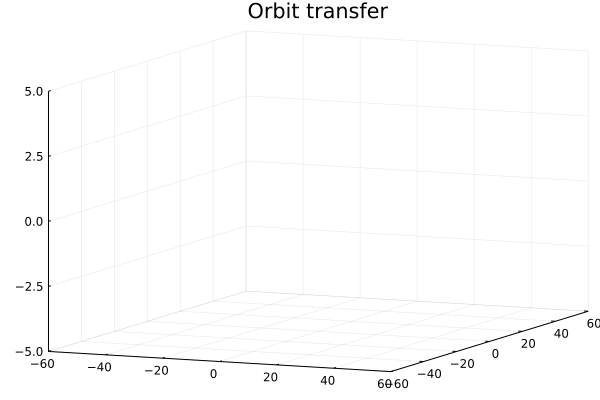

In [21]:
if nl_sol.converged
    tf = nl_sol.x[1]; p0 = nl_sol.x[2:end]
else
    error("Not converged")
end

ode_sol = f((t0, tf), x0, p0)
t  = ode_sol.t; N = size(t, 1)
P  = ode_sol[1, :]
ex = ode_sol[2, :]
ey = ode_sol[3, :]
hx = ode_sol[4, :]
hy = ode_sol[5, :]
L  = ode_sol[6, :]
cL = cos.(L)
sL = sin.(L)
W  = 1.0 .+ ex.*cL + ey.*sL
Z  = hx.*sL - hy.*cL
C  = 1.0 .+ hx.^2 + hy.^2
q1 = P .*( (1.0 .+ hx.^2 - hy.^2).*cL + 2*hx.*hy.*sL ) ./ (C.*W)
q2 = P .*( (1.0 .- hx.^2 + hy.^2).*sL + 2*hx.*hy.*cL ) ./ (C.*W)
q3 = 2*P.*Z ./ (C.*W)

plt1 = plot3d(1, xlim = (-60, 60), ylim = (-60, 60), zlim = (-5, 5), title = "Orbit transfer", legend=false)

@gif for i=1:N
    push!(plt1, q1[i], q2[i], q3[i])
end every N÷100

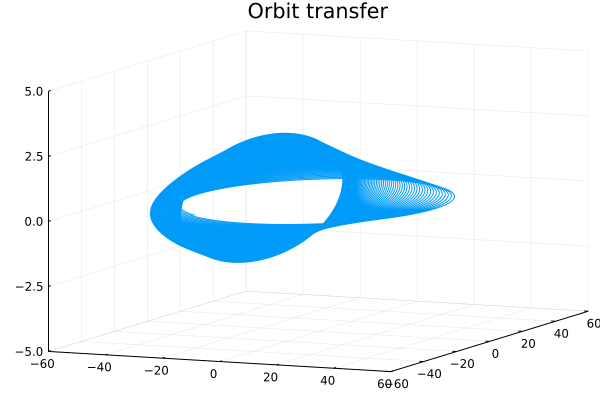

In [22]:
plt2 = plot3d(q1, q2, q3, xlim = (-60, 60), ylim = (-60, 60), zlim = (-5, 5), title = "Orbit transfer", legend=false)

[thumbnail](kepler-j.jpg)